In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pathlib

from collections import Counter
from sklearn.preprocessing import StandardScaler

import keras.backend as K
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping



2023-02-16 18:36:02.940531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 18:36:04.944541: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-16 18:36:04.944684: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-16 18:36:04.944695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
train_data_dir = pathlib.Path("/home/khoi/Documents/Ai project/Emotion_Detection_CNN/data_base/archive/train")
print(train_data_dir)

test_data_dir = pathlib.Path("/home/khoi/Documents/Ai project/Emotion_Detection_CNN/data_base/archive/test")
print(test_data_dir)

# Image size

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 16
EPOCHS = 100
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10


/home/khoi/Documents/Ai project/Emotion_Detection_CNN/data_base/archive/train
/home/khoi/Documents/Ai project/Emotion_Detection_CNN/data_base/archive/test


In [3]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '/home/khoi/Documents/Ai project/Emotion_Detection_CNN/data_base/archive/train',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '/home/khoi/Documents/Ai project/Emotion_Detection_CNN/data_base/archive/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# create model structure
emotion_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])
emotion_model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

emotion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

2023-02-16 18:36:08.724305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 18:36:08.836637: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/khoi/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-16 18:36:08.836664: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-16 18:36:08.837831: I tensorflow/core/platform

In [5]:
checkpoint = ModelCheckpoint("./modelCNN.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [checkpoint,reduce_learningrate]

epochs = 10

emotion_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [6]:
emotion_model_info = emotion_model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//validation_generator.batch_size,
                                epochs=30,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

/tmp/ipykernel_93729/4134867772.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(generator=train_generator,


Epoch 1/30
448/448 [==============================] - ETA: 0s - loss: 1.7328 - accuracy: 0.3003WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 290s 646ms/step - loss: 1.7328 - accuracy: 0.3003 - val_loss: 1.5325 - val_accuracy: 0.3943 - lr: 0.0010
Epoch 2/30
448/448 [==============================] - ETA: 0s - loss: 1.4587 - accuracy: 0.4336WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 296s 661ms/step - loss: 1.4587 - accuracy: 0.4336 - val_loss: 1.3265 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 3/30
448/448 [==============================] - ETA: 0s - loss: 1.3041 - accuracy: 0.4999WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 220s 491ms/step - loss: 1.3041 - accuracy: 0.4999 - val_loss: 1.2403 - val_accuracy: 0.5248 - lr: 0.0010
Epoch 4/30
448/448 [==============================] - ETA: 0s - loss: 1.2163 - accuracy: 0.5367WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 189s 421ms/step - loss: 1.2163 - accuracy: 0.5367 - val_loss: 1.1768 - val_accuracy: 0.5508 - lr: 0.0010
Epoch 5/30
448/448 [==============================] - ETA: 0s - loss: 1.1633 - accuracy: 0.5553WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 137s 307ms/step - loss: 1.1633 - accuracy: 0.5553 - val_loss: 1.1497 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 6/30
448/448 [==============================] - ETA: 0s - loss: 1.1120 - accuracy: 0.5793WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 138s 309ms/step - loss: 1.1120 - accuracy: 0.5793 - val_loss: 1.1107 - val_accuracy: 0.5794 - lr: 0.0010
Epoch 7/30
448/448 [==============================] - ETA: 0s - loss: 1.0673 - accuracy: 0.5974WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 138s 308ms/step - loss: 1.0673 - accuracy: 0.5974 - val_loss: 1.1102 - val_accuracy: 0.5771 - lr: 0.0010
Epoch 8/30
448/448 [==============================] - ETA: 0s - loss: 1.0294 - accuracy: 0.6092WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 137s 306ms/step - loss: 1.0294 - accuracy: 0.6092 - val_loss: 1.0960 - val_accuracy: 0.5861 - lr: 0.0010
Epoch 9/30
448/448 [==============================] - ETA: 0s - loss: 0.9880 - accuracy: 0.6286WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 137s 305ms/step - loss: 0.9880 - accuracy: 0.6286 - val_loss: 1.0852 - val_accuracy: 0.5914 - lr: 0.0010
Epoch 10/30
448/448 [==============================] - ETA: 0s - loss: 0.9539 - accuracy: 0.6415WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 138s 308ms/step - loss: 0.9539 - accuracy: 0.6415 - val_loss: 1.0717 - val_accuracy: 0.5995 - lr: 0.0010
Epoch 11/30
448/448 [==============================] - ETA: 0s - loss: 0.9162 - accuracy: 0.6533WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 137s 305ms/step - loss: 0.9162 - accuracy: 0.6533 - val_loss: 1.0659 - val_accuracy: 0.5940 - lr: 0.0010
Epoch 12/30
448/448 [==============================] - ETA: 0s - loss: 0.8874 - accuracy: 0.6671WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 136s 304ms/step - loss: 0.8874 - accuracy: 0.6671 - val_loss: 1.0702 - val_accuracy: 0.6102 - lr: 0.0010
Epoch 13/30
448/448 [==============================] - ETA: 0s - loss: 0.8460 - accuracy: 0.6822WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 136s 304ms/step - loss: 0.8460 - accuracy: 0.6822 - val_loss: 1.0592 - val_accuracy: 0.6112 - lr: 0.0010
Epoch 14/30
448/448 [==============================] - ETA: 0s - loss: 0.8129 - accuracy: 0.6985WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 132s 294ms/step - loss: 0.8129 - accuracy: 0.6985 - val_loss: 1.0679 - val_accuracy: 0.6184 - lr: 0.0010
Epoch 15/30
448/448 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.7070WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 122s 271ms/step - loss: 0.7846 - accuracy: 0.7070 - val_loss: 1.0609 - val_accuracy: 0.6184 - lr: 0.0010
Epoch 16/30
448/448 [==============================] - ETA: 0s - loss: 0.7614 - accuracy: 0.7164WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
448/448 [==============================] - 121s 270ms/step - loss: 0.7614 - accuracy: 0.7164 - val_loss: 1.0717 - val_accuracy: 0.6176 - lr: 0.0010
Epoch 17/30
448/448 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.7573WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 121s 269ms/step - loss: 0.6511 - accuracy: 0.7573 - val_loss: 1.0658 - val_accuracy: 0.6242 - lr: 2.0000e-04
Epoch 18/30
448/448 [==============================] - ETA: 0s - loss: 0.6194 - accuracy: 0.7715WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 121s 271ms/step - loss: 0.6194 - accuracy: 0.7715 - val_loss: 1.0729 - val_accuracy: 0.6303 - lr: 2.0000e-04
Epoch 19/30
448/448 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.7823WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 19: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
448/448 [==============================] - 122s 271ms/step - loss: 0.5989 - accuracy: 0.7823 - val_loss: 1.0680 - val_accuracy: 0.6338 - lr: 2.0000e-04
Epoch 20/30
448/448 [==============================] - ETA: 0s - loss: 0.5738 - accuracy: 0.7882WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 121s 270ms/step - loss: 0.5738 - accuracy: 0.7882 - val_loss: 1.0786 - val_accuracy: 0.6321 - lr: 4.0000e-05
Epoch 21/30
448/448 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.7918WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 120s 269ms/step - loss: 0.5625 - accuracy: 0.7918 - val_loss: 1.0818 - val_accuracy: 0.6327 - lr: 4.0000e-05
Epoch 22/30
448/448 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.7919WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 22: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
448/448 [==============================] - 121s 269ms/step - loss: 0.5623 - accuracy: 0.7919 - val_loss: 1.0879 - val_accuracy: 0.6297 - lr: 4.0000e-05
Epoch 23/30
448/448 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.7941WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 120s 268ms/step - loss: 0.5568 - accuracy: 0.7941 - val_loss: 1.0859 - val_accuracy: 0.6311 - lr: 8.0000e-06
Epoch 24/30
448/448 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.7937WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 121s 270ms/step - loss: 0.5575 - accuracy: 0.7937 - val_loss: 1.0863 - val_accuracy: 0.6316 - lr: 8.0000e-06
Epoch 25/30
448/448 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.7969WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 25: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
448/448 [==============================] - 120s 268ms/step - loss: 0.5518 - accuracy: 0.7969 - val_loss: 1.0876 - val_accuracy: 0.6328 - lr: 8.0000e-06
Epoch 26/30
448/448 [==============================] - ETA: 0s - loss: 0.5555 - accuracy: 0.7946WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 121s 271ms/step - loss: 0.5555 - accuracy: 0.7946 - val_loss: 1.0877 - val_accuracy: 0.6325 - lr: 1.6000e-06
Epoch 27/30
448/448 [==============================] - ETA: 0s - loss: 0.5545 - accuracy: 0.7971WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 157s 350ms/step - loss: 0.5545 - accuracy: 0.7971 - val_loss: 1.0884 - val_accuracy: 0.6316 - lr: 1.6000e-06
Epoch 28/30
448/448 [==============================] - ETA: 0s - loss: 0.5522 - accuracy: 0.7973WARNING:tensorflow:Can save best model only with val_acc available, skipping.



Epoch 28: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
448/448 [==============================] - 161s 359ms/step - loss: 0.5522 - accuracy: 0.7973 - val_loss: 1.0883 - val_accuracy: 0.6311 - lr: 1.6000e-06
Epoch 29/30
448/448 [==============================] - ETA: 0s - loss: 0.5594 - accuracy: 0.7942WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 164s 366ms/step - loss: 0.5594 - accuracy: 0.7942 - val_loss: 1.0881 - val_accuracy: 0.6316 - lr: 3.2000e-07
Epoch 30/30
448/448 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.7937WARNING:tensorflow:Can save best model only with val_acc available, skipping.


448/448 [==============================] - 249s 557ms/step - loss: 0.5558 - accuracy: 0.7937 - val_loss: 1.0882 - val_accuracy: 0.6314 - lr: 3.2000e-07


In [14]:
import pandas as pd


# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(emotion_model_info.history) 

# or save to csv: 
hist_csv_file = 'historyCNN_au.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [15]:
emotion_model.save('modelCNN_augu.h5')  # creates a HDF5 file 'my_model.h5'

In [16]:
CNNBase_Score = emotion_model.evaluate(validation_generator)

print("Val Loss: {:.5f}".format(CNNBase_Score[0]))
print("Val Accuracy: {:.2f}%".format(CNNBase_Score[1] * 100))

113/113 [==============================] - 6s 51ms/step - loss: 1.0884 - accuracy: 0.6314
Val Loss: 1.08835
Val Accuracy: 63.14%


In [17]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
    

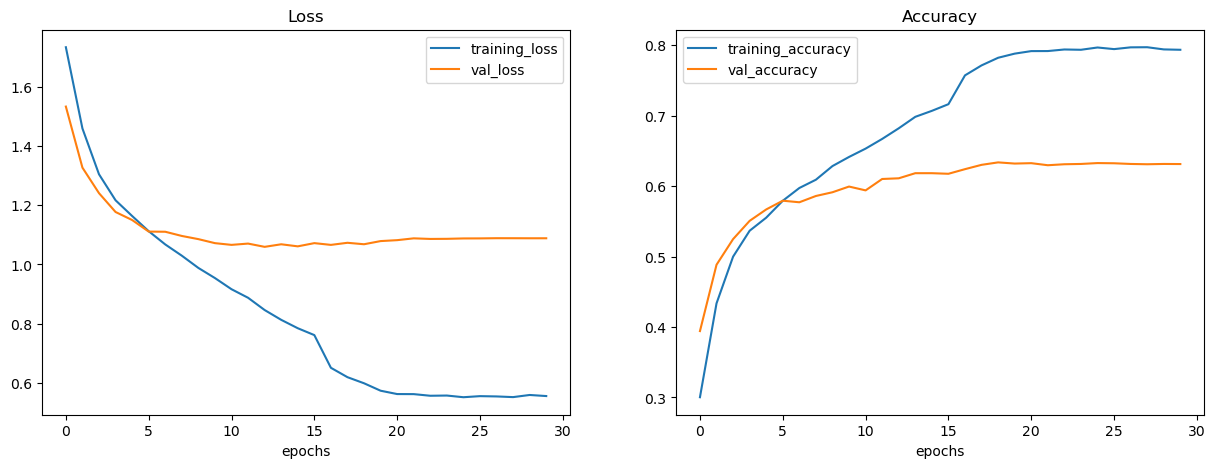

In [18]:
plot_curves(emotion_model_info)

In [12]:
CNNBase_Predict = emotion_model.predict(validation_generator)

# Choosing highest probalbilty class in every prediction 
CNNBase_Predict = np.argmax(CNNBase_Predict, axis=1)



113/113 [==============================] - 10s 89ms/step


<Figure size 640x480 with 0 Axes>

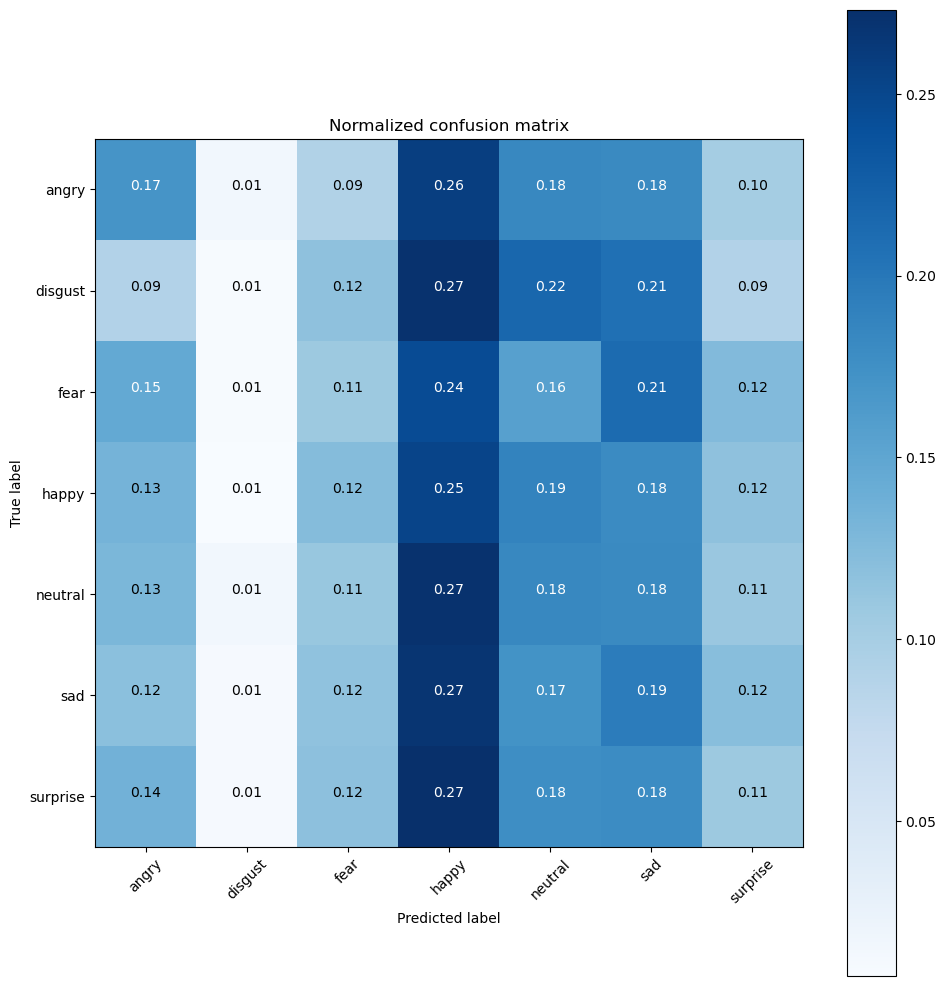

In [13]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(validation_generator.labels, CNNBase_Predict)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=validation_generator.class_indices.keys(), title='Normalized confusion matrix')
plt.show()

